This notebook demonstrates positive and unlabeled (pu) learning methods explained in the paper [Learning Classifiers from Only Positive and Unlabeled Data](https://cseweb.ucsd.edu/~elkan/posonly.pdf).

The Python package of pu learning is https://pulearn.github.io/pulearn/doc/pulearn/.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pulearn
import seaborn as sns
from sklearn import metrics, model_selection, ensemble

sns.set_theme()

# Selected Completely At Random (SCAR) Assumption

## Prepare Data

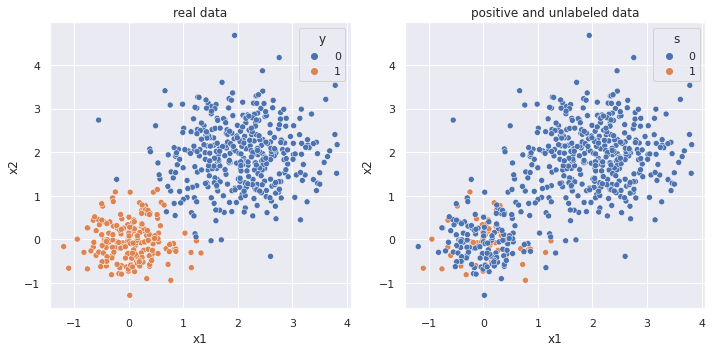

In [2]:
def create_sample_data(n_positive: int, n_negative: int, labeled_ratio: float, mu1=[0,0], mu2=[2,2], sigma1=0.2, sigma2=0.5):
    """ Generate two kinds of multivariate Gaussian variables and unlabel a part of them.
    """
    n = n_positive + n_negative
    n_labeled = int(n_positive * labeled_ratio)
    ret = pd.DataFrame({
        'y': np.concatenate([np.repeat(1, n_positive), np.repeat(0, n_negative)]),
        's': np.concatenate([np.repeat(1, n_labeled), np.repeat(0, n-n_labeled)]),
    })
    sigma1 = sigma1 * np.identity(2)
    sigma2 = sigma2 * np.identity(2)
    X = np.r_[
        np.random.multivariate_normal(mu1, sigma1, n_positive),
        np.random.multivariate_normal(mu2, sigma2, n_negative)
    ]
    ret[['x1', 'x2']] = X
    return ret


n_positive = 200
n_negative = 400
labeled_ratio = 0.3
data = create_sample_data(n_positive, n_negative, labeled_ratio)

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
# true
sns.scatterplot(data=data, x='x1', y='x2', hue='y', ax=axes[0])
axes[0].set_title("real data")
# unlabeled
sns.scatterplot(data=data, x='x1', y='x2', hue='s', ax=axes[1])
axes[1].set_title("positive and unlabeled data")
plt.show()

## Traditinal Classifier

In [3]:
use_cols = ['x1', 'x2']
X = data[use_cols].to_numpy()
s = data['s'].to_numpy()
y = data['y'].to_numpy()

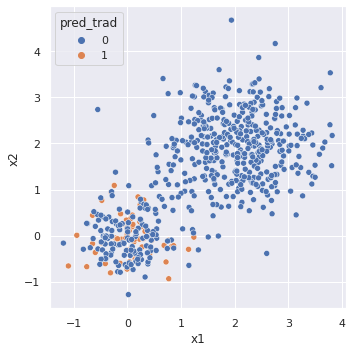

In [4]:
estimator = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator.fit(X, s)
data['pred_trad'] = estimator.predict(X)
data['pred_proba_trad'] = estimator.predict_proba(X)[:, 1]
data.head()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
sns.scatterplot(data=data, x='x1', y='x2', hue='pred_trad', ax=ax)
plt.show()

## PU Learning

In [5]:
def visualize(data: pd.DataFrame):
    """
    """
    sns.set_theme()
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)
    # true
    sns.scatterplot(data=data, x='x1', y='x2', hue='y', ax=axes[0][0])
    axes[0][0].set_title("real data")
    # unlabeled
    sns.scatterplot(data=data, x='x1', y='x2', hue='s', ax=axes[0][1])
    axes[0][1].set_title("positive and unlabeled data")
    # traditinal classifier
    sns.scatterplot(data=data, x='x1', y='x2', hue='pred_trad', ax=axes[1][0])
    axes[1][0].set_title('traditional classifier')
    # non-traditinal classifier
    sns.scatterplot(data=data, x='x1', y='x2', hue='pred', ax=axes[1][1])
    axes[1][1].set_title('non-traditional classifier')
    
    return fig

### Learning a traditinal classifier from non-traditional input

In [6]:
simple_result = data.copy()

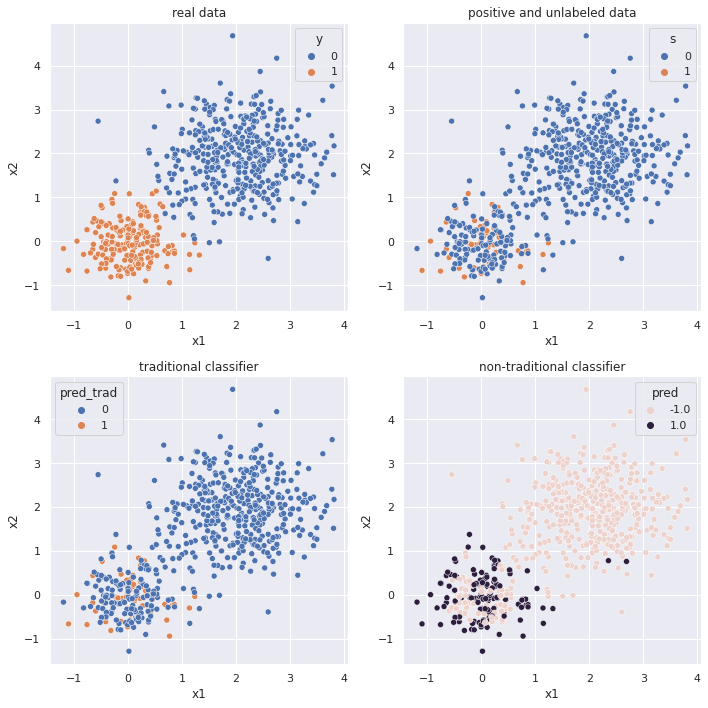

In [7]:
clf = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator = pulearn.ElkanotoPuClassifier(clf, hold_out_ratio=0.3)
estimator.fit(X, s)
simple_result['pred'] = estimator.predict(X)
simple_result['pred_proba'] = estimator.predict_proba(X)
simple_result['pred_proba'] = simple_result['pred_proba'].apply(lambda x: 1 if x>1 else x)

fig = visualize(simple_result)
fig.show()

In [8]:
print(
    f"traditional classifier:     {metrics.roc_auc_score(simple_result['y'], simple_result['pred_proba_trad']):.4}",
    f"non-traditional classifier: {metrics.roc_auc_score(simple_result['y'], simple_result['pred_proba']):.4}",
    sep='\n'
)

traditional classifier:     0.9846
non-traditional classifier: 0.9758


In [9]:
simple_result[['y', 's', 'pred_proba_trad', 'pred_proba']].sum()

y                  200.000000
s                   60.000000
pred_proba_trad     59.985000
pred_proba         133.952542
dtype: float64

### Weighning unlabled examples

In [10]:
weighted_result = data.copy()

In [11]:
class WeightedPUClassifier(object):
    
    def __init__(self, clf, n_folds=3):
        self.clf = clf
        self.n_folds = n_folds

    def fit(self, X: np.ndarray, s: np.ndarray):
        """Execute the weighted PU learning 
        """
        # Calculate the value of c by the traditinal classifier
        c = np.zeros(self.n_folds)
        skf = model_selection.StratifiedKFold(n_splits=self.n_folds, shuffle=True)
        for i, (train_idx, test_idx) in enumerate(skf.split(X, s)):
            self.clf.fit(X[train_idx], s[train_idx])
            c[i] = self.clf.predict_proba(X[test_idx][s[test_idx]==1])[:, 1].mean()
        self.c = c.mean()
        print('c:', self.c)

        # Generate necessary data for the weighted pu learning
        X_positive = X[s==1]
        X_unlabeled = X[s==0]
        n_positive = X_positive.shape[0]
        n_unlabeled = X_unlabeled.shape[0]

        X_train = np.r_[X_positive, X_unlabeled, X_unlabeled]
        y_train = np.concatenate([np.repeat(1, n_positive), np.repeat(1, n_unlabeled), np.repeat(0, n_unlabeled)])

        g = self.clf.predict_proba(X_unlabeled)[: ,1]
        w = ((1 - self.c)/self.c) * (g/ (1 - g))
        sample_weight = np.concatenate([np.repeat(1.0, n_positive), w, 1-w])
        self.clf.fit(X_train, y_train, sample_weight=sample_weight)
        
    def predict_proba(self, X: np.ndarray):
        return self.clf.predict_proba(X)[:, 1]
    
    def predict(self, X: np.ndarray, threshold=0.5):
        return [1 if p>threshold else 0 for p in self.predict_proba(X)]

c: 0.2505


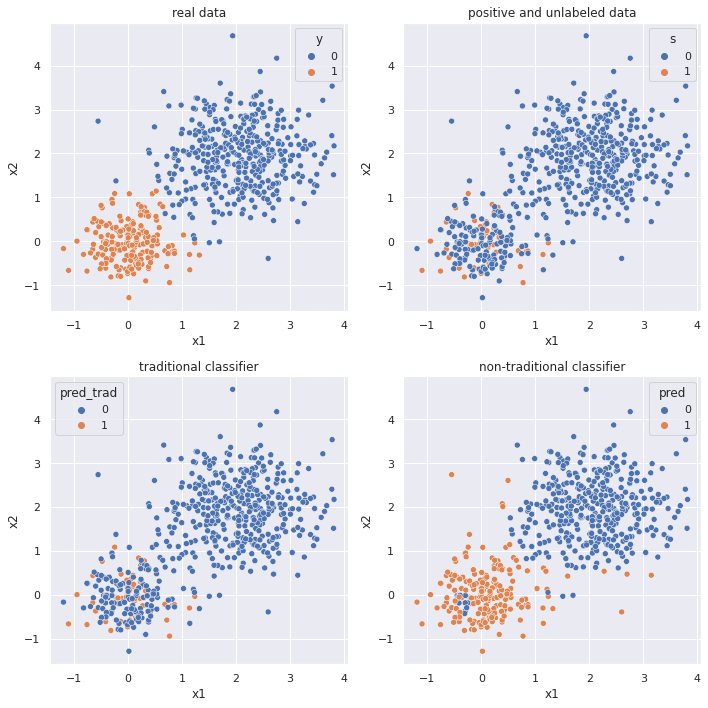

In [12]:
clf = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator = WeightedPUClassifier(clf)
estimator.fit(X, s)

weighted_result['pred'] = estimator.predict(X)
weighted_result['pred_proba'] = estimator.predict_proba(X)
weighted_result['pred_proba'] = weighted_result['pred_proba'].apply(lambda x: 1 if x>1 else x)

fig = visualize(weighted_result)
fig.show()

In [13]:
print(
    f"traditional classifier:     {metrics.roc_auc_score(weighted_result['y'], weighted_result['pred_proba_trad']):.4}",
    f"non-traditional classifier: {metrics.roc_auc_score(weighted_result['y'], weighted_result['pred_proba']):.4}",
    sep='\n'
)

traditional classifier:     0.9846
non-traditional classifier: 0.9787


In [14]:
weighted_result[['y', 's', 'pred_proba_trad', 'pred_proba']].sum()

y                  200.000000
s                   60.000000
pred_proba_trad     59.985000
pred_proba         206.459064
dtype: float64

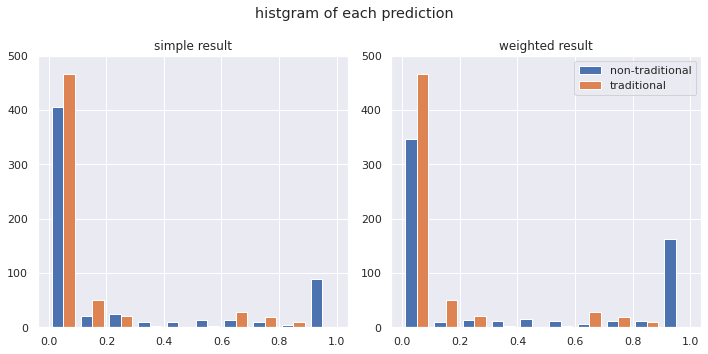

In [15]:
# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
# non-weighted 
axes[0].hist(x=[simple_result['pred_proba'], weighted_result['pred_proba_trad']], bins=10, label=['non-traditional', 'traditional'])
axes[0].set_title("simple result")
axes[0].set_ylim(0, 500)
# weighted
axes[1].hist(x=[weighted_result['pred_proba'], weighted_result['pred_proba_trad']], bins=10, label=['non-traditional', 'traditional'])
axes[1].set_title("weighted result")
axes[1].set_ylim(0, 500)
plt.suptitle('histgram of each prediction')
plt.legend()
plt.show()

#### pulearn package

The implementaion in the pulearn package is slightly different (miss?) from the original paper (see [the source code](https://github.com/pulearn/pulearn/blob/master/pulearn/elkanoto.py#L122-L263)).

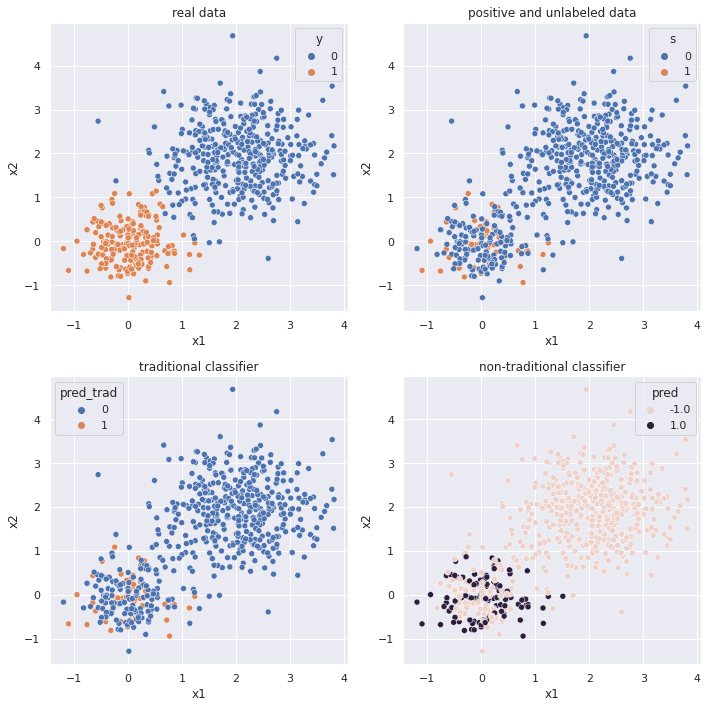

In [16]:
clf = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator = pulearn.WeightedElkanotoPuClassifier(
    estimator=clf,
    labeled=weighted_result['s'].sum(),
    unlabeled=len(weighted_result) - weighted_result['s'].sum(),
    hold_out_ratio=0.3
)
estimator.fit(X, s)

weighted_result['pred'] = estimator.predict(X)
weighted_result['pred_proba'] = estimator.predict_proba(X)
weighted_result['pred_proba'] = weighted_result['pred_proba'].apply(lambda x: 1 if x>1 else x)

fig = visualize(weighted_result)
fig.show()

In [17]:
print(
    f"traditional classifier:     {metrics.roc_auc_score(weighted_result['y'], weighted_result['pred_proba_trad']):.4}",
    f"non-traditional classifier: {metrics.roc_auc_score(weighted_result['y'], weighted_result['pred_proba']):.4}",
    sep='\n'
)

traditional classifier:     0.9846
non-traditional classifier: 0.9875


In [18]:
weighted_result[['y', 's', 'pred_proba_trad', 'pred_proba']].sum()

y                  200.000000
s                   60.000000
pred_proba_trad     59.985000
pred_proba         115.536006
dtype: float64

# Appendix

## For Single Data

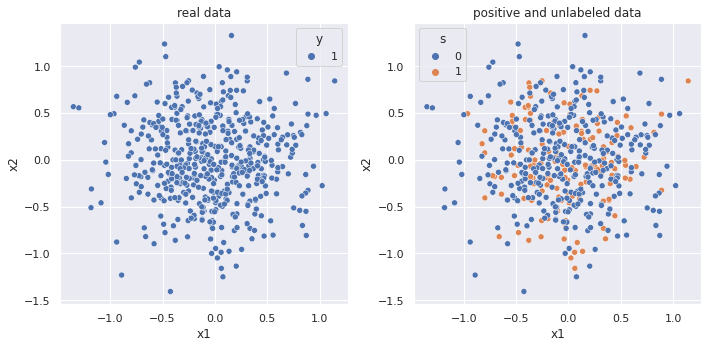

In [19]:
n_positive = 500
n_negative = 0
labeled_ratio = 0.3
data = create_sample_data(n_positive, n_negative, labeled_ratio)

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
# true
sns.scatterplot(data=data, x='x1', y='x2', hue='y', ax=axes[0])
axes[0].set_title("real data")

# unlabeled
sns.scatterplot(data=data, x='x1', y='x2', hue='s', ax=axes[1])
axes[1].set_title("positive and unlabeled data")
plt.show()

In [20]:
use_cols = ['x1', 'x2']
X = data[use_cols].to_numpy()
s = data['s'].to_numpy()
y = data['y'].to_numpy()

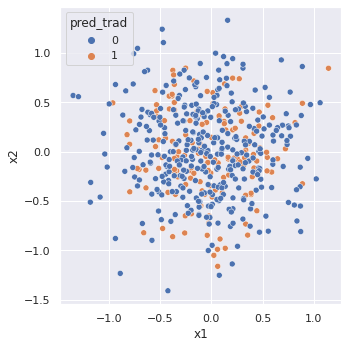

In [21]:
# traditional classifier
estimator = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator.fit(X, s)
data['pred_trad'] = estimator.predict(X)
data['pred_proba_trad'] = estimator.predict_proba(X)[:, 1]
data.head()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
sns.scatterplot(data=data, x='x1', y='x2', hue='pred_trad', ax=ax)
plt.show()

### Learning a traditinal classifier from non-traditional input

In [22]:
simple_result = data.copy()

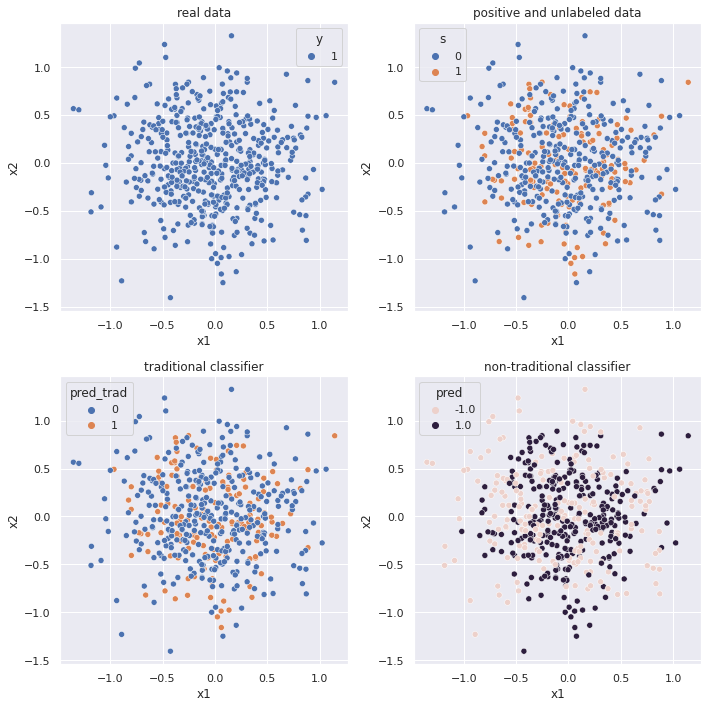

In [23]:
clf = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator = pulearn.ElkanotoPuClassifier(clf, hold_out_ratio=0.3)
estimator.fit(X, s)
simple_result['pred'] = estimator.predict(X)
simple_result['pred_proba'] = estimator.predict_proba(X)
simple_result['pred_proba'] = simple_result['pred_proba'].apply(lambda x: 1 if x>1 else x)

fig = visualize(simple_result)
fig.show()

In [24]:
simple_result[['y', 's', 'pred_proba_trad', 'pred_proba']].sum()

y                  500.000000
s                  150.000000
pred_proba_trad    151.270000
pred_proba         314.278689
dtype: float64

### Weighning unlabled examples

In [25]:
weighted_result = data.copy()

c: 0.32853333333333334


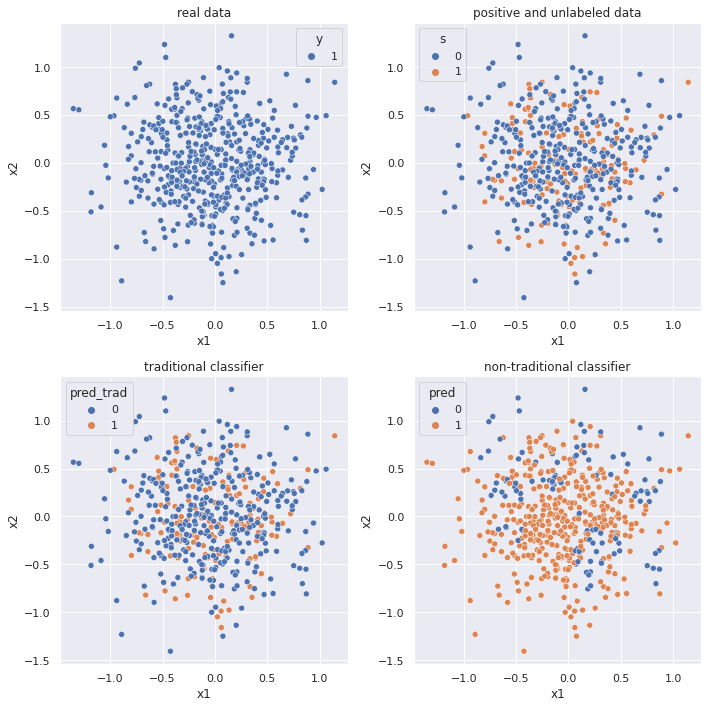

In [26]:
clf = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator = WeightedPUClassifier(clf)
estimator.fit(X, s)

weighted_result['pred'] = estimator.predict(X)
weighted_result['pred_proba'] = estimator.predict_proba(X)
weighted_result['pred_proba'] = weighted_result['pred_proba'].apply(lambda x: 1 if x>1 else x)

fig = visualize(weighted_result)
fig.show()

In [27]:
weighted_result[['y', 's', 'pred_proba_trad', 'pred_proba']].sum()

y                  500.000000
s                  150.000000
pred_proba_trad    151.270000
pred_proba         386.634269
dtype: float64

## Different Variance

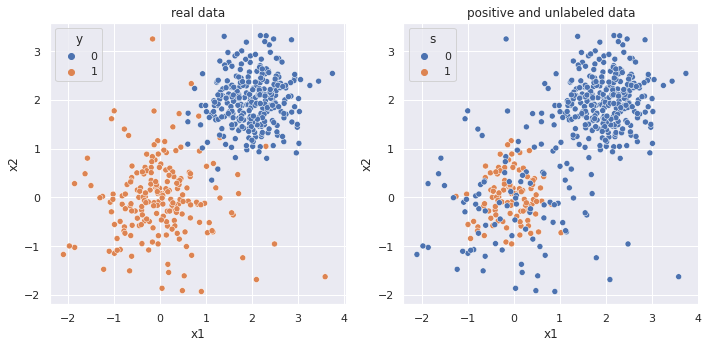

In [28]:
def create_sample_data(n_positive: int, n_negative: int, labeled_ratio: float, mu1=[0,0], mu2=[2,2], sigma1=0.2, sigma2=0.3):
    """ Generate two kinds of multivariate Gaussian variables and unlabel a part of them.
    """
    n = n_positive + n_negative
    n_labeled = int(n_positive * labeled_ratio)
    ret = pd.DataFrame({
        'y': np.concatenate([np.repeat(1, n_positive), np.repeat(0, n_negative)]),
        's': np.concatenate([np.repeat(1, n_labeled), np.repeat(0, n-n_labeled)]),
    })
    s1 = sigma1 * np.identity(2)
    s1_gap = sigma1*5 * np.identity(2)
    s2 = sigma2 * np.identity(2)
    X = np.r_[
        np.random.multivariate_normal(mu1, s1, n_positive//2),
        np.random.multivariate_normal(mu1, s1_gap, n_positive//2),
        np.random.multivariate_normal(mu2, s2, n_negative)
    ]
    ret[['x1', 'x2']] = X
    return ret


n_positive = 200
n_negative = 300
labeled_ratio = 0.5
data = create_sample_data(n_positive, n_negative, labeled_ratio)

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
# true
sns.scatterplot(data=data, x='x1', y='x2', hue='y', ax=axes[0])
axes[0].set_title("real data")
# unlabeled
sns.scatterplot(data=data, x='x1', y='x2', hue='s', ax=axes[1])
axes[1].set_title("positive and unlabeled data")
plt.show()

In [29]:
use_cols = ['x1', 'x2']
X = data[use_cols].to_numpy()
s = data['s'].to_numpy()
y = data['y'].to_numpy()

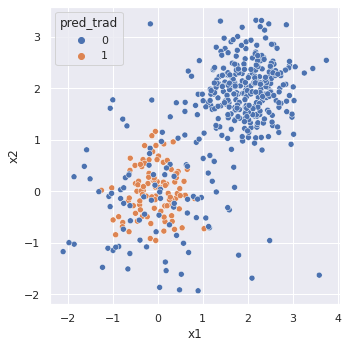

In [30]:
# traditional classifier
estimator = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator.fit(X, s)
data['pred_trad'] = estimator.predict(X)
data['pred_proba_trad'] = estimator.predict_proba(X)[:, 1]
data.head()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
sns.scatterplot(data=data, x='x1', y='x2', hue='pred_trad', ax=ax)
plt.show()

### Weighning unlabled examples

In [31]:
weighted_result = data.copy()

c: 0.6811437908496732


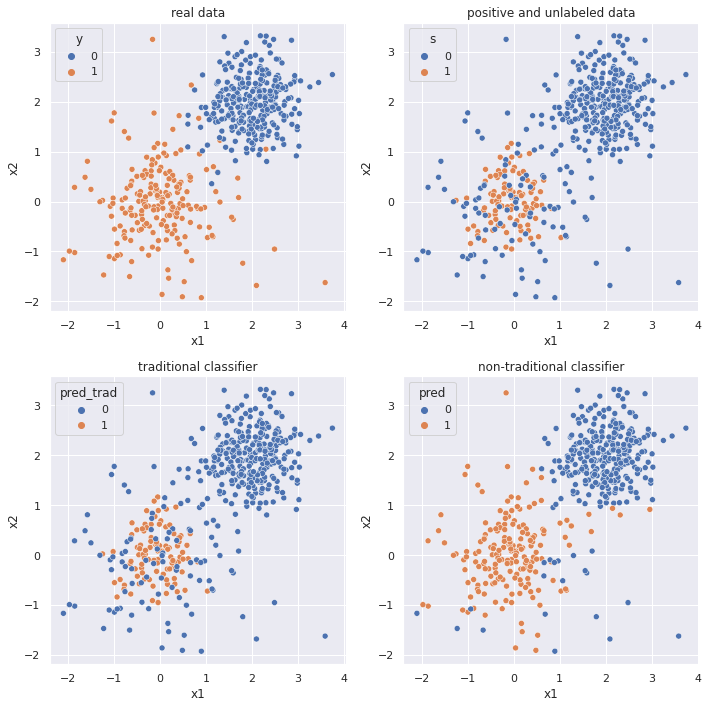

In [32]:
clf = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini')
estimator = WeightedPUClassifier(clf)
estimator.fit(X, s)

weighted_result['pred'] = estimator.predict(X)
weighted_result['pred_proba'] = estimator.predict_proba(X)
weighted_result['pred_proba'] = weighted_result['pred_proba'].apply(lambda x: 1 if x>1 else x)

fig = visualize(weighted_result)
fig.show()

In [33]:
weighted_result[['y', 's', 'pred_proba_trad', 'pred_proba']].sum()

y                  200.00000
s                  100.00000
pred_proba_trad    100.06000
pred_proba         177.40372
dtype: float64